# imports & catalogues

In [35]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import all_fctns
import os
import scipy as sp

# from dr_tools.sami_fluxcal import sami_read_apspec

SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"

shared_catalogue_filepath = Source_dir +  "SAMI_TOOLS_SMC_MSPA4681\\shared_catalogues\\"
gassig_statistics_catalogue = "gassig_statistics.fits"

def refresh_module():
    import importlib
    import all_fctns
    import EW_Ha_tools
    importlib.reload(EW_Ha_tools)
    importlib.reload(all_fctns)

ifs_path = Source_dir + "sami_tools_smc_mspa4681\\some_sample_ifs\\"

def sami_read_apspec(hdulist,extname,doareacorr=False,bugfix=True):

    sami_flux_blue = hdulist[extname].data
    header = hdulist[extname].header
    crval1=header['CRVAL1']
    cdelt1=header['CDELT1']
    crpix1=header['CRPIX1']
    naxis1=header['NAXIS1']
    x=np.arange(naxis1)+1
    L0=crval1-crpix1*cdelt1 #Lc-pix*dL        
    sami_lam_blue=L0+x*cdelt1

    if (doareacorr):
        # fix bug in ap spec code:
        if (bugfix):
            areacorr=areacorr/2.0
        areacorr = header['AREACORR']
        sami_flux_blue = sami_flux_blue * areacorr

    return sami_flux_blue,sami_lam_blue


# def get_blue_spectra(CATID, sample_spectra_filepath=sample_spectra_filepath):
#     apspecfile_blue = os.path.join(sample_spectra_filepath,str(CATID)+'_A_spectrum_1-4-arcsec_blue.fits')
#     hdulist = fits.open(apspecfile_blue)
#     sami_flux_blue,sami_lam_blue = sami_read_apspec(hdulist,0,doareacorr=False)
#     return sami_flux_blue, sami_lam_blue





def plot_line_lam(ax,z, annotations=True):

    """Plot location of main emission and abs lines at redshift
    of current object."""
    
    # get ylims
    ymin, ymax = ax.set_ylim()
    yrange = ymax - ymin

    h=0.1
    #z=0
    # Ha
    Ha_lam = (1+z) * 6564.61
    ax.axvline(Ha_lam, color='grey', zorder=-1)


    # Hb
    Hb_lam = (1+z) * 4862.68
    ax.axvline(Hb_lam, color='grey', zorder=-1)
    
    # NII
    NII_lam = (1+z) * 6549.86
    ax.axvline(NII_lam, color='grey', zorder=-1)
    
    # OIII
    OIII_lam = (1+z) * 5008.24
    ax.axvline(OIII_lam, color='grey', zorder=-1)
    
    # SII
    SII_lam = (1+z) * 6718.29
    ax.axvline(SII_lam, color='grey', zorder=-1)

    if annotations:
        ax.text(Ha_lam+10, h*yrange+ymin, '$H\\alpha$')
        ax.text(Hb_lam+10, h*yrange+ymin, '$H\\beta$')
        ax.text(NII_lam-90, h*yrange+ymin, '$NII$')
        ax.text(OIII_lam+10, h*yrange+ymin, '$OIII$')
        ax.text(SII_lam+10, h*yrange+ymin, '$SII$')
        
    return None

AttributeError: module 'all_fctns' has no attribute 'ifs_path'

# plotting spectra

In [ ]:
# all_fctns.get_z_best(catalogue_filepath, 9011900711)

ls = [1,2]
ls[np.isin(ls, [9011900711])]

TypeError: only integer scalar arrays can be converted to a scalar index

[6427.819 6492.819] [6632.819 6697.819]
Region 1 flux: 0.20 +/- 0.01


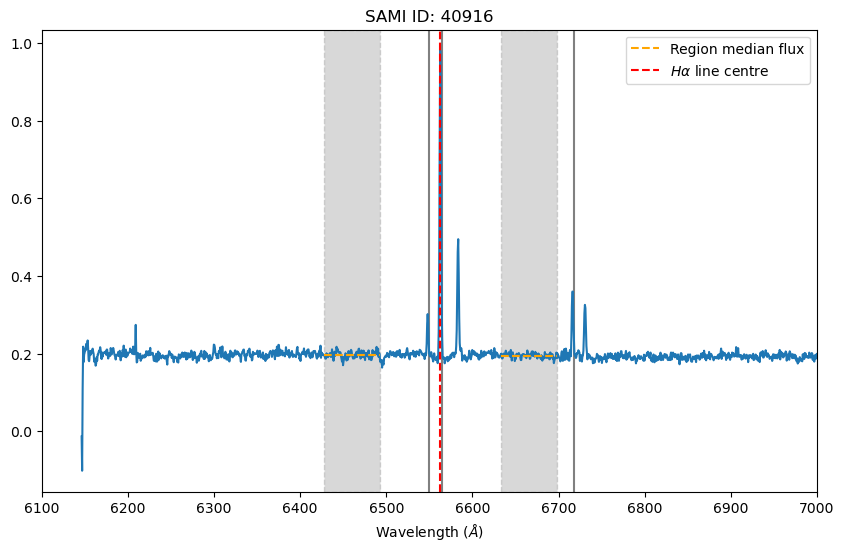

In [25]:
refresh_module()
CATIDs = 40916, 9011900711, 298590, 6821
CATID = CATIDs[0]

fig, ax = plt.subplots(1,1, figsize=(10,6))

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID)
ax.plot(sami_lam_red_zcorr, sami_flux_red)
plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(6100,7000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')


def get_redshift_corrected_spectra(CATID, ifs_path=ifs_path):
    apspecfile_red = os.path.join(ifs_path,str(CATID), str(CATID)+'_A_spectrum_1-4-arcsec_red.fits')
    hdulist = fits.open(apspecfile_red)
    sami_flux_red,sami_lam_red = sami_read_apspec(hdulist,0,doareacorr=False)
    hdulist.close()
    redshift = all_fctns.get_z_best(catalogue_filepath, [CATID], only_spec=True)
    sami_lam_red_zcorr = sami_lam_red / (1 + redshift)
    return sami_flux_red, sami_lam_red_zcorr


def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(Ha_lam, color='red', linestyle='--', label='$H\\alpha$ line centre')
ax.legend()


[6427.819 6492.819] [6632.819 6697.819]
Region 1 flux: 0.20 +/- 0.01


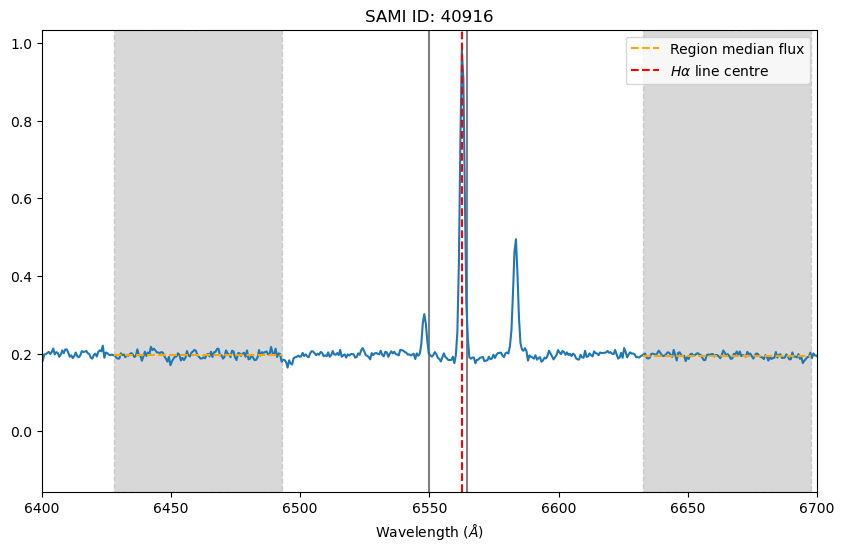

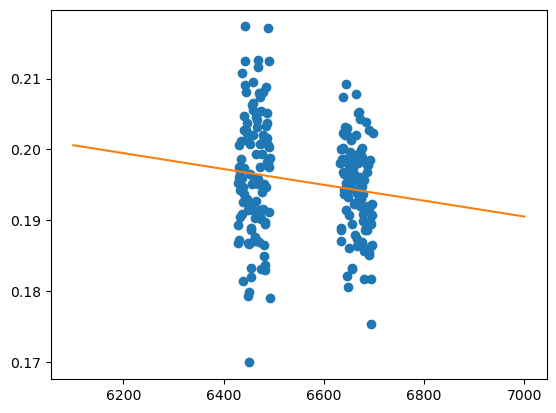

In [29]:
refresh_module()
CATIDs = 40916, 9011900711, 298590, 6821
CATID = CATIDs[0]

fig, ax = plt.subplots(1,1, figsize=(10,6))

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID)
ax.plot(sami_lam_red_zcorr, sami_flux_red)
plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(6100,7000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')


def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(Ha_lam, color='red', linestyle='--', label='$H\\alpha$ line centre')
ax.legend()

ax.set_xlim(6400, 6700)

plt.show()

plt.figure()

region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
regions = (region1, region2)

# get the relevant points for line fitting
regions_mask = (sami_lam_red_zcorr >= regions[0][0]) & (sami_lam_red_zcorr <= regions[0][1]) | (sami_lam_red_zcorr >= regions[1][0]) & (sami_lam_red_zcorr <= regions[1][1])
regions_sami_lam_red_zcorr = sami_lam_red_zcorr[regions_mask]
regions_sami_flux_red = sami_flux_red[regions_mask]

plt.plot(regions_sami_lam_red_zcorr, regions_sami_flux_red, 'o')

# fit a line to these points
res = sp.stats.linregress(regions_sami_lam_red_zcorr, regions_sami_flux_red)
slope, intercept, slope_err, intercept_err = res.slope, res.intercept, res.stderr, res.intercept_stderr
continuum_flux = slope*Ha_lam + intercept
continuum_flux_err = np.sqrt( (slope_err*Ha_lam)**2 + intercept_err**2 )
lambda_fit = np.linspace(6100, 7000, 1000)
plt.plot(lambda_fit, slope*lambda_fit + intercept, label='Linear fit to continuum regions')

In [43]:

def get_redshift_corrected_spectra(CATID, ifs_path=ifs_path):
    apspecfile_red = os.path.join(ifs_path,str(CATID), str(CATID)+'_A_spectrum_1-4-arcsec_red.fits')
    hdulist = fits.open(apspecfile_red)
    sami_flux_red,sami_lam_red = sami_read_apspec(hdulist,0,doareacorr=False)
    hdulist.close()
    redshift = all_fctns.get_z_best(catalogue_filepath, [CATID], only_spec=True)
    sami_lam_red_zcorr = sami_lam_red / (1 + redshift)
    return sami_flux_red, sami_lam_red_zcorr


def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err


def get_continuum_flux(CATID, regions, spectra_filepath=None, estimation_method='median', sami_flux_red=None, sami_lam_red=None, already_zcorr=False, catalogue_filepath=catalogue_filepath):
    """Get the continuum flux at Halpha for a given CATID.\\
    Two continuum estimation methods implemented: 'median' and 'linefit'.\\
    This function can take in a pre-loaded spectra or relevant CATID.
    
    returns continuum_flux, continuum_flux_err
    """
    Ha_lam = 6562.819

    # check regions has two arrays of length 2
    assert len(regions) == 2, TypeError("Regions must be an iterable object of two arrays.")
    region1, region2 = regions

    assert len(region1)==2 and len(region2)==2, TypeError("Each region must be an array of length 2.")

    # check that spectra are provided or spectra_filepath is provided
    if (sami_flux_red is None or sami_lam_red is None) and spectra_filepath is None:
        raise ValueError("Either spectra or spectra_filepath must be provided.")
    
    # first check if spectra are provided, also check if they are already redshift corrected
    elif sami_flux_red is not None and sami_lam_red is not None and already_zcorr:
        sami_flux_red = sami_flux_red
        sami_lam_red_zcorr = sami_lam_red

    elif sami_flux_red is not None and sami_lam_red is not None and not already_zcorr:
        redshift = all_fctns.get_z_best(catalogue_filepath, [CATID], only_spec=True)
        sami_lam_red_zcorr = sami_lam_red / (1 + redshift)

    else: # only other possible case is that spectra_filepath is provided
        sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID, spectra_filepath)

    # now estimate the continuum flux
    if estimation_method == 'median': # two regions, median of both, midpoint of those is the continuum flux error from std of regions
        region_fluxes = np.zeros(2)
        region_flux_errs = np.zeros(2)

        for i, region in enumerate(regions):
            region_mask = (sami_lam_red_zcorr >= region[0]) & (sami_lam_red_zcorr <= region[1])
            region_fluxes[i] = np.median(sami_flux_red[region_mask])
            region_flux_errs[i] = np.std(sami_flux_red[region_mask])

        continuum_flux = np.mean(region_fluxes)
        continuum_flux_err = np.sqrt(np.sum(region_flux_errs**2)) / 2
        print(continuum_flux_err)

        continuum_flux_err = continuum_flux * np.sqrt(np.sum( (region_flux_errs/region_fluxes)**2 )) #
        print(continuum_flux_err)

    elif estimation_method == 'linefit': #linear fit to the two regions, evaluate at Ha_lam to get continuum flux, error from fit errors
        # get the relevant points for line fitting
        regions_mask = (sami_lam_red_zcorr >= regions[0][0]) & (sami_lam_red_zcorr <= regions[0][1]) | (sami_lam_red_zcorr >= regions[1][0]) & (sami_lam_red_zcorr <= regions[1][1])
        regions_sami_lam_red_zcorr = sami_lam_red_zcorr[regions_mask]
        regions_sami_flux_red = sami_flux_red[regions_mask]

        # fit a line to these points
        res = sp.stats.linregress(regions_sami_lam_red_zcorr, regions_sami_flux_red)
        slope, intercept, slope_err, intercept_err = res.slope, res.intercept, res.stderr, res.intercept_stderr
        continuum_flux = slope*Ha_lam + intercept
        continuum_flux_err = np.sqrt( (slope_err*Ha_lam)**2 + intercept_err**2 )
    else:
        raise NotImplementedError("Only 'median' and 'linefit' estimation methods are implemented.")
    
    return continuum_flux, continuum_flux_err
    

def get_Halpha_EW(CATID, catalogue_filepath=catalogue_filepath, ifs_path=ifs_path, estimation_method='median', SAMI_spectra_table_hdu=None,  sami_flux_red=None, sami_lam_red=None, already_zcorr=False):
    """Get the Halpha equivalent width for a given CATID in the 1.4 arcsec aperture.\\
    Two continuum estimation methods implemented: 'median' and 'linefit'.\\
    This function can take in a pre-loaded SAMI_spectra_table (EmissionLine1compDR3.fits) to avoid re-loading the catalogue for each CATID.\\
    This function can also take in a pre-loaded spectra or relevant CATID. to feed into the continuum flux calculation. (see get_continuum_flux function)\\

    returns Ha_EW, Ha_EW_err
    """
    # set the regions for collecting continuum flux, should be symmetric around Halpha
    region_width = 65
    region_separation = 140
    Ha_lam = 6562.819
    region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
    region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  


    # read in the emission line catalogue if not provided
    if SAMI_spectra_table_hdu is None:
        SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
        with fits.open( os.path.join(catalogue_filepath + SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
            SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)
    else:
        SAMI_spectra_table_hdu = SAMI_spectra_table_hdu

    
    HAlpha_flux, HAlpha_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == CATID], 'H Alpha')

    # get the continuum flux
    continuum_flux, continuum_flux_err = get_continuum_flux(CATID, (region1, region2), ifs_path, estimation_method=estimation_method, 
                                                            sami_flux_red=sami_flux_red, sami_lam_red=sami_lam_red, already_zcorr=already_zcorr, catalogue_filepath=catalogue_filepath)

    # calculate the EW
    Ha_EW = HAlpha_flux / continuum_flux
    Ha_EW_err = Ha_EW * np.sqrt((HAlpha_error / HAlpha_flux)**2 + (continuum_flux_err / continuum_flux)**2)

        
    return Ha_EW, Ha_EW_err


def get_Halpha_EW_table(CATIDs, catalogue_filepath=catalogue_filepath, ifs_path=ifs_path):
    """Get the Halpha equivalent width for a given CATID.
    
    Uses the EmissionLine1compDR3.fits catalogue, and individual spectra.
    """
    # set the regions for collecting continuum flux, should be symmetric around Halpha
    region_width = 65
    region_separation = 140
    Ha_lam = 6562.819
    region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
    region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  


    # read in the emission line catalogue
    SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
    with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
        SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

    # initialise HA_EW astropy table
    Ha_EW_table = Table(names=['CATID', 'HAlpha_EW_MedianFit', 'HAlpha_EW_err_MedianFit', 'HAlpha_EW_LineFit', 'HAlpha_EW_err_LineFit'], dtype=[int, float, float, float, float])

    
    # iterate over CATIDs
    for CATID in CATIDs:
        HAlpha_flux, HAlpha_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == CATID], 'H Alpha')

        Ha_EW_medianfit, Ha_EW_medianfit_err = get_Halpha_EW(CATID, catalogue_filepath=catalogue_filepath, ifs_path=ifs_path, estimation_method='median', SAMI_spectra_table_hdu=SAMI_spectra_table_hdu)
        Ha_EW_linefit, Ha_EW_linefit_err = get_Halpha_EW(CATID, catalogue_filepath=catalogue_filepath, ifs_path=ifs_path, estimation_method='linefit', SAMI_spectra_table_hdu=SAMI_spectra_table_hdu)
        # add row to table

        Ha_EW_table.add_row([CATID, Ha_EW_medianfit, Ha_EW_medianfit_err, Ha_EW_linefit, Ha_EW_linefit_err])
        
    return Ha_EW_table

get_Halpha_EW_table(CATIDs)

0.00545738892291568
0.010906330007173462
0.012204080345398917
0.02424430256959412
0.01506906236484489
0.03023169490669929
0.033971849064574414
0.06886815329459547


CATID,HAlpha_EW_MedianFit,HAlpha_EW_err_MedianFit,HAlpha_EW_LineFit,HAlpha_EW_err_LineFit
int64,float64,float64,float64,float64
40916,10.152496587502498,0.5751340684389937,10.160142567085396,2.3999914642170133
9011900711,0.01634351412744184,0.03656297964581625,0.016297731129559904,0.03652766705403445
298590,8.358235187814408,0.2831222157971041,8.368069404276577,1.1441057578990552
6821,753.8102210052308,389.5251689243251,716.1965058647987,1478.4184035514984


NameError: name 'EW_Ha_tools' is not defined

In [44]:
with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

CATID = 15165
SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == CATID]['HALPHA_1_4_ARCSECOND']

1.5370374
0.9380064


# WHaN plot

['CATID', 'HAlpha_EW_MedianFit', 'HAlpha_EW_err_MedianFit', 'HAlpha_EW_LineFit', 'HAlpha_EW_err_LineFit']


(-1.0, 2.12)

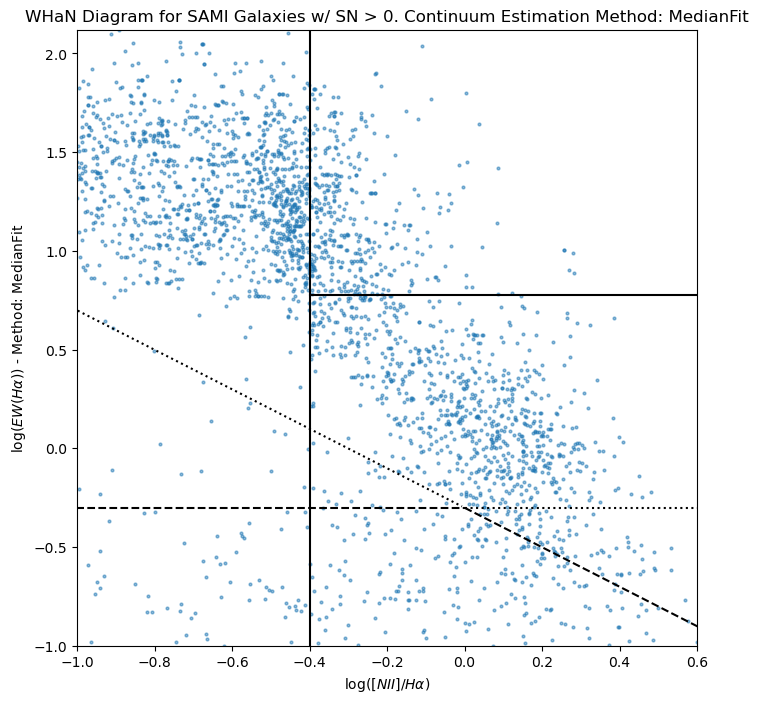

In [94]:

estimation_methods = ('MedianFit', 'LineFit')[:1]


with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

print(Ha_EW_table.colnames)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()

reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])

for method in estimation_methods:
    fig, ax = plt.subplots(1,1, figsize=(8,8))


    # print(reduced_spectra_table)

    reduced_HA_EW_table = Ha_EW_table.copy()
    reduced_HA_EW_table.keep_columns(['CATID', f'HAlpha_EW_{method}', f'HAlpha_EW_err_{method}'])
    reduced_HA_EW_table.rename_columns([f'HAlpha_EW_{method}', f'HAlpha_EW_err_{method}'], ['HAlpha_EW', 'HAlpha_EW_err'])

    HA_EW_NII_HA_table = join(reduced_HA_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')

    SN_lim=0
    SN_mask = (HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) & (HA_EW_NII_HA_table['HAlpha_EW'] / HA_EW_NII_HA_table['HAlpha_EW_err'] > SN_lim)

    plt.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), np.log10(HA_EW_NII_HA_table['HAlpha_EW'][SN_mask]), 'o', markersize=2, alpha=0.5)



    plt.xlabel(r"$\log([NII]/H\alpha)$")
    plt.ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

    plt.title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}. Continuum Estimation Method: {method}")


def plot_WHaN_lines(ax, paper='Cid Fernandes et al. (2011)'):
    xrange = ax.get_xlim()
    yrange = ax.get_ylim()

    xs = np.linspace(xrange[0], xrange[1], 1000)

    if paper == 'Cid Fernandes et al. (2011)':
        m_line = (np.log10(5)-np.log10(0.5))/(-1-0)
        c_line = np.log10(0.5)

        # uncertain lines
        ax.plot(xs[xs<0], m_line*xs[xs<0] + c_line, 'k:')
        ax.plot([0, xrange[1]], [np.log10(0.5)]*2, 'k:')

        # passive galaxy lines
        ax.plot(xs[xs>0], m_line*xs[xs>0] + c_line, 'k--')
        ax.plot([xrange[0], 0], [np.log10(0.5)]*2, 'k--')

        ax.plot([-0.4, xrange[1]], [np.log10(6)]*2, color='k') # K06 Seyfert/LINER line
        ax.axvline(-0.4, color='k') # S06 SF/AGN line



    # m_line = (5-0.5)/(-1-0)
    # c_line = 0.5

    # plt.plot(xs, m_line*xs + c_line, 'k.')
    # plt.plot([-1, 0], [np.log10(5), np.log10(0.5)], 'k.', linewidth=1)

plot_WHaN_lines(ax)


# add the WHaN plot lines
plt.xlim(-1, 0.6)
plt.ylim(-1, 2.12)

# plt.axhline(0.5, color='k')
# plt.axhline(-0.3, xmax=0, color='k')
# plt.plot([-2, 0], [-0.3]*2, 'k-')
# plt.plot([-0.5, 2], [0.75]*2, 'k-')
# plt.axhline(-0.3, xmin=0, color='k', linestyle='--')
# plt.axhline(-0.5, xmin=0.5, color='k')
